<a href="https://colab.research.google.com/github/sahar-mariam/kannada-sentiment-analysis/blob/main/ensemble_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q transformers datasets evaluate scikit-learn matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate
import numpy as np
import torch
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import mode

# Step 1: Load and preprocess dataset
df = pd.read_csv("balanced_dataset.csv")

# Encode sentiment labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sentiment"])

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
)

# Step 2: Define tokenization and training pipeline
def train_and_evaluate_model(model_name, train_texts, train_labels, test_texts, test_labels, num_labels):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
    test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

    train_dataset = Dataset.from_dict({
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'labels': list(train_labels)
    })
    test_dataset = Dataset.from_dict({
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'labels': list(test_labels)
    })

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_steps=10,
        logging_dir="./logs",
        disable_tqdm=True
    )

    metric_accuracy = evaluate.load("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "report": classification_report(labels, preds, output_dict=True)
        }

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    predictions = trainer.predict(test_dataset).predictions
    final_preds = np.argmax(predictions, axis=1)

    report = classification_report(test_labels, final_preds, target_names=label_encoder.classes_)
    accuracy = accuracy_score(test_labels, final_preds)

    return final_preds, accuracy, report

In [3]:
# Step 3: Train and evaluate all models
models = {
    "mBERT": "bert-base-multilingual-cased",
    "DistilBERT": "distilbert-base-multilingual-cased",
    "MuRIL": "google/muril-base-cased",
    "IndicBERT": "ai4bharat/indic-bert",
    "XLM-R": "xlm-roberta-base"
}

all_predictions = {}
accuracies = {}
reports = {}

for model_alias, model_path in models.items():
    print(f"Training and evaluating {model_alias}...")
    preds, acc, rep = train_and_evaluate_model(
        model_path, train_texts, train_labels, test_texts, test_labels, num_labels=3
    )
    all_predictions[model_alias] = preds
    accuracies[model_alias] = acc
    reports[model_alias] = rep


Training and evaluating mBERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sahar-mb (sahar-mb-uvce) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'loss': 1.1223, 'grad_norm': 6.239465236663818, 'learning_rate': 4.9145299145299147e-05, 'epoch': 0.05128205128205128}
{'loss': 1.0984, 'grad_norm': 2.8281826972961426, 'learning_rate': 4.829059829059829e-05, 'epoch': 0.10256410256410256}
{'loss': 1.1007, 'grad_norm': 4.706565856933594, 'learning_rate': 4.7435897435897435e-05, 'epoch': 0.15384615384615385}
{'loss': 1.1135, 'grad_norm': 2.6983625888824463, 'learning_rate': 4.6581196581196586e-05, 'epoch': 0.20512820512820512}
{'loss': 1.1126, 'grad_norm': 3.9263532161712646, 'learning_rate': 4.572649572649573e-05, 'epoch': 0.2564102564102564}
{'loss': 1.1035, 'grad_norm': 4.486413955688477, 'learning_rate': 4.4871794871794874e-05, 'epoch': 0.3076923076923077}
{'loss': 1.1197, 'grad_norm': 2.331353187561035, 'learning_rate': 4.401709401709402e-05, 'epoch': 0.358974358974359}
{'loss': 1.114, 'grad_norm': 5.80151891708374, 'learning_rate': 4.316239316239317e-05, 'epoch': 0.41025641025641024}
{'loss': 1.1135, 'grad_norm': 4.896724700927734

Trainer is attempting to log a value of "{'0': {'precision': 0.375, 'recall': 0.05791505791505792, 'f1-score': 0.10033444816053512, 'support': 259.0}, '1': {'precision': 0.5428571428571428, 'recall': 0.14671814671814673, 'f1-score': 0.23100303951367782, 'support': 259.0}, '2': {'precision': 0.37031484257871067, 'recall': 0.9536679536679536, 'f1-score': 0.5334773218142549, 'support': 259.0}, 'accuracy': 0.3861003861003861, 'macro avg': {'precision': 0.4293906618119512, 'recall': 0.38610038610038605, 'f1-score': 0.2882716031628226, 'support': 777.0}, 'weighted avg': {'precision': 0.4293906618119512, 'recall': 0.3861003861003861, 'f1-score': 0.2882716031628226, 'support': 777.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 1.081884503364563, 'eval_accuracy': 0.3861003861003861, 'eval_report': {'0': {'precision': 0.375, 'recall': 0.05791505791505792, 'f1-score': 0.10033444816053512, 'support': 259.0}, '1': {'precision': 0.5428571428571428, 'recall': 0.14671814671814673, 'f1-score': 0.23100303951367782, 'support': 259.0}, '2': {'precision': 0.37031484257871067, 'recall': 0.9536679536679536, 'f1-score': 0.5334773218142549, 'support': 259.0}, 'accuracy': 0.3861003861003861, 'macro avg': {'precision': 0.4293906618119512, 'recall': 0.38610038610038605, 'f1-score': 0.2882716031628226, 'support': 777.0}, 'weighted avg': {'precision': 0.4293906618119512, 'recall': 0.3861003861003861, 'f1-score': 0.2882716031628226, 'support': 777.0}}, 'eval_runtime': 5.2276, 'eval_samples_per_second': 148.633, 'eval_steps_per_second': 9.373, 'epoch': 1.0}
{'loss': 1.0743, 'grad_norm': 3.274595022201538, 'learning_rate': 3.290598290598291e-05, 'epoch': 1.0256410256410255}
{'loss': 1.0464, 'grad_norm': 4.7352352142333

Trainer is attempting to log a value of "{'0': {'precision': 0.6150442477876106, 'recall': 0.5366795366795367, 'f1-score': 0.5731958762886598, 'support': 259.0}, '1': {'precision': 0.4740740740740741, 'recall': 0.4942084942084942, 'f1-score': 0.4839319470699433, 'support': 259.0}, '2': {'precision': 0.6583629893238434, 'recall': 0.7142857142857143, 'f1-score': 0.6851851851851852, 'support': 259.0}, 'accuracy': 0.5817245817245817, 'macro avg': {'precision': 0.582493770395176, 'recall': 0.5817245817245817, 'f1-score': 0.5807710028479294, 'support': 777.0}, 'weighted avg': {'precision': 0.582493770395176, 'recall': 0.5817245817245817, 'f1-score': 0.5807710028479294, 'support': 777.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.8556797504425049, 'eval_accuracy': 0.5817245817245817, 'eval_report': {'0': {'precision': 0.6150442477876106, 'recall': 0.5366795366795367, 'f1-score': 0.5731958762886598, 'support': 259.0}, '1': {'precision': 0.4740740740740741, 'recall': 0.4942084942084942, 'f1-score': 0.4839319470699433, 'support': 259.0}, '2': {'precision': 0.6583629893238434, 'recall': 0.7142857142857143, 'f1-score': 0.6851851851851852, 'support': 259.0}, 'accuracy': 0.5817245817245817, 'macro avg': {'precision': 0.582493770395176, 'recall': 0.5817245817245817, 'f1-score': 0.5807710028479294, 'support': 777.0}, 'weighted avg': {'precision': 0.582493770395176, 'recall': 0.5817245817245817, 'f1-score': 0.5807710028479294, 'support': 777.0}}, 'eval_runtime': 5.0026, 'eval_samples_per_second': 155.32, 'eval_steps_per_second': 9.795, 'epoch': 2.0}
{'loss': 0.7833, 'grad_norm': 7.759589672088623, 'learning_rate': 1.581196581196581e-05, 'epoch': 2.051282051282051}
{'loss': 0.8489, 'grad_norm': 10.26780128

Trainer is attempting to log a value of "{'0': {'precision': 0.5985915492957746, 'recall': 0.6563706563706564, 'f1-score': 0.6261510128913443, 'support': 259.0}, '1': {'precision': 0.5122950819672131, 'recall': 0.4826254826254826, 'f1-score': 0.4970178926441352, 'support': 259.0}, '2': {'precision': 0.7429718875502008, 'recall': 0.7142857142857143, 'f1-score': 0.7283464566929134, 'support': 259.0}, 'accuracy': 0.6177606177606177, 'macro avg': {'precision': 0.6179528396043962, 'recall': 0.6177606177606177, 'f1-score': 0.6171717874094643, 'support': 777.0}, 'weighted avg': {'precision': 0.6179528396043961, 'recall': 0.6177606177606177, 'f1-score': 0.6171717874094643, 'support': 777.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.8186860084533691, 'eval_accuracy': 0.6177606177606177, 'eval_report': {'0': {'precision': 0.5985915492957746, 'recall': 0.6563706563706564, 'f1-score': 0.6261510128913443, 'support': 259.0}, '1': {'precision': 0.5122950819672131, 'recall': 0.4826254826254826, 'f1-score': 0.4970178926441352, 'support': 259.0}, '2': {'precision': 0.7429718875502008, 'recall': 0.7142857142857143, 'f1-score': 0.7283464566929134, 'support': 259.0}, 'accuracy': 0.6177606177606177, 'macro avg': {'precision': 0.6179528396043962, 'recall': 0.6177606177606177, 'f1-score': 0.6171717874094643, 'support': 777.0}, 'weighted avg': {'precision': 0.6179528396043961, 'recall': 0.6177606177606177, 'f1-score': 0.6171717874094643, 'support': 777.0}}, 'eval_runtime': 4.9167, 'eval_samples_per_second': 158.033, 'eval_steps_per_second': 9.966, 'epoch': 3.0}
{'train_runtime': 316.497, 'train_samples_per_second': 29.46, 'train_steps_per_second': 1.848, 'train_loss': 0.9556685985662998, 'epoch': 3.0}


Trainer is attempting to log a value of "{'0': {'precision': 0.5985915492957746, 'recall': 0.6563706563706564, 'f1-score': 0.6261510128913443, 'support': 259.0}, '1': {'precision': 0.5122950819672131, 'recall': 0.4826254826254826, 'f1-score': 0.4970178926441352, 'support': 259.0}, '2': {'precision': 0.7429718875502008, 'recall': 0.7142857142857143, 'f1-score': 0.7283464566929134, 'support': 259.0}, 'accuracy': 0.6177606177606177, 'macro avg': {'precision': 0.6179528396043962, 'recall': 0.6177606177606177, 'f1-score': 0.6171717874094643, 'support': 777.0}, 'weighted avg': {'precision': 0.6179528396043961, 'recall': 0.6177606177606177, 'f1-score': 0.6171717874094643, 'support': 777.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.8186860084533691, 'eval_accuracy': 0.6177606177606177, 'eval_report': {'0': {'precision': 0.5985915492957746, 'recall': 0.6563706563706564, 'f1-score': 0.6261510128913443, 'support': 259.0}, '1': {'precision': 0.5122950819672131, 'recall': 0.4826254826254826, 'f1-score': 0.4970178926441352, 'support': 259.0}, '2': {'precision': 0.7429718875502008, 'recall': 0.7142857142857143, 'f1-score': 0.7283464566929134, 'support': 259.0}, 'accuracy': 0.6177606177606177, 'macro avg': {'precision': 0.6179528396043962, 'recall': 0.6177606177606177, 'f1-score': 0.6171717874094643, 'support': 777.0}, 'weighted avg': {'precision': 0.6179528396043961, 'recall': 0.6177606177606177, 'f1-score': 0.6171717874094643, 'support': 777.0}}, 'eval_runtime': 4.9445, 'eval_samples_per_second': 157.144, 'eval_steps_per_second': 9.91, 'epoch': 3.0}
Training and evaluating DistilBERT...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.113, 'grad_norm': 2.27492094039917, 'learning_rate': 4.9145299145299147e-05, 'epoch': 0.05128205128205128}
{'loss': 1.0912, 'grad_norm': 1.4127159118652344, 'learning_rate': 4.829059829059829e-05, 'epoch': 0.10256410256410256}
{'loss': 1.0865, 'grad_norm': 1.9345743656158447, 'learning_rate': 4.7435897435897435e-05, 'epoch': 0.15384615384615385}
{'loss': 1.0841, 'grad_norm': 1.8318921327590942, 'learning_rate': 4.6581196581196586e-05, 'epoch': 0.20512820512820512}
{'loss': 1.0527, 'grad_norm': 1.971553087234497, 'learning_rate': 4.572649572649573e-05, 'epoch': 0.2564102564102564}
{'loss': 1.0704, 'grad_norm': 2.333893060684204, 'learning_rate': 4.4871794871794874e-05, 'epoch': 0.3076923076923077}
{'loss': 0.9974, 'grad_norm': 3.016376495361328, 'learning_rate': 4.401709401709402e-05, 'epoch': 0.358974358974359}
{'loss': 1.0144, 'grad_norm': 3.3426854610443115, 'learning_rate': 4.316239316239317e-05, 'epoch': 0.41025641025641024}
{'loss': 0.9655, 'grad_norm': 4.78029537200927

Trainer is attempting to log a value of "{'0': {'precision': 0.6091954022988506, 'recall': 0.4092664092664093, 'f1-score': 0.4896073903002309, 'support': 259.0}, '1': {'precision': 0.46153846153846156, 'recall': 0.416988416988417, 'f1-score': 0.4381338742393509, 'support': 259.0}, '2': {'precision': 0.5555555555555556, 'recall': 0.7915057915057915, 'f1-score': 0.6528662420382165, 'support': 259.0}, 'accuracy': 0.5392535392535392, 'macro avg': {'precision': 0.5420964731309559, 'recall': 0.5392535392535392, 'f1-score': 0.5268691688592662, 'support': 777.0}, 'weighted avg': {'precision': 0.542096473130956, 'recall': 0.5392535392535392, 'f1-score': 0.5268691688592662, 'support': 777.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.9634371995925903, 'eval_accuracy': 0.5392535392535392, 'eval_report': {'0': {'precision': 0.6091954022988506, 'recall': 0.4092664092664093, 'f1-score': 0.4896073903002309, 'support': 259.0}, '1': {'precision': 0.46153846153846156, 'recall': 0.416988416988417, 'f1-score': 0.4381338742393509, 'support': 259.0}, '2': {'precision': 0.5555555555555556, 'recall': 0.7915057915057915, 'f1-score': 0.6528662420382165, 'support': 259.0}, 'accuracy': 0.5392535392535392, 'macro avg': {'precision': 0.5420964731309559, 'recall': 0.5392535392535392, 'f1-score': 0.5268691688592662, 'support': 777.0}, 'weighted avg': {'precision': 0.542096473130956, 'recall': 0.5392535392535392, 'f1-score': 0.5268691688592662, 'support': 777.0}}, 'eval_runtime': 2.5286, 'eval_samples_per_second': 307.283, 'eval_steps_per_second': 19.378, 'epoch': 1.0}
{'loss': 0.9204, 'grad_norm': 3.9325878620147705, 'learning_rate': 3.290598290598291e-05, 'epoch': 1.0256410256410255}
{'loss': 0.8521, 'grad_norm': 3.4187

Trainer is attempting to log a value of "{'0': {'precision': 0.6016260162601627, 'recall': 0.5714285714285714, 'f1-score': 0.5861386138613861, 'support': 259.0}, '1': {'precision': 0.4826254826254826, 'recall': 0.4826254826254826, 'f1-score': 0.4826254826254826, 'support': 259.0}, '2': {'precision': 0.6911764705882353, 'recall': 0.7258687258687259, 'f1-score': 0.7080979284369114, 'support': 259.0}, 'accuracy': 0.5933075933075933, 'macro avg': {'precision': 0.5918093231579602, 'recall': 0.5933075933075932, 'f1-score': 0.5922873416412601, 'support': 777.0}, 'weighted avg': {'precision': 0.5918093231579602, 'recall': 0.5933075933075933, 'f1-score': 0.5922873416412601, 'support': 777.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.8535393476486206, 'eval_accuracy': 0.5933075933075933, 'eval_report': {'0': {'precision': 0.6016260162601627, 'recall': 0.5714285714285714, 'f1-score': 0.5861386138613861, 'support': 259.0}, '1': {'precision': 0.4826254826254826, 'recall': 0.4826254826254826, 'f1-score': 0.4826254826254826, 'support': 259.0}, '2': {'precision': 0.6911764705882353, 'recall': 0.7258687258687259, 'f1-score': 0.7080979284369114, 'support': 259.0}, 'accuracy': 0.5933075933075933, 'macro avg': {'precision': 0.5918093231579602, 'recall': 0.5933075933075932, 'f1-score': 0.5922873416412601, 'support': 777.0}, 'weighted avg': {'precision': 0.5918093231579602, 'recall': 0.5933075933075933, 'f1-score': 0.5922873416412601, 'support': 777.0}}, 'eval_runtime': 2.4835, 'eval_samples_per_second': 312.868, 'eval_steps_per_second': 19.73, 'epoch': 2.0}
{'loss': 0.6035, 'grad_norm': 7.163366317749023, 'learning_rate': 1.581196581196581e-05, 'epoch': 2.051282051282051}
{'loss': 0.6376, 'grad_norm': 12.23089

Trainer is attempting to log a value of "{'0': {'precision': 0.5967741935483871, 'recall': 0.5714285714285714, 'f1-score': 0.5838264299802761, 'support': 259.0}, '1': {'precision': 0.47104247104247104, 'recall': 0.47104247104247104, 'f1-score': 0.47104247104247104, 'support': 259.0}, '2': {'precision': 0.6962962962962963, 'recall': 0.7258687258687259, 'f1-score': 0.7107750472589792, 'support': 259.0}, 'accuracy': 0.5894465894465895, 'macro avg': {'precision': 0.5880376536290516, 'recall': 0.5894465894465895, 'f1-score': 0.5885479827605754, 'support': 777.0}, 'weighted avg': {'precision': 0.5880376536290515, 'recall': 0.5894465894465895, 'f1-score': 0.5885479827605754, 'support': 777.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.9125804305076599, 'eval_accuracy': 0.5894465894465895, 'eval_report': {'0': {'precision': 0.5967741935483871, 'recall': 0.5714285714285714, 'f1-score': 0.5838264299802761, 'support': 259.0}, '1': {'precision': 0.47104247104247104, 'recall': 0.47104247104247104, 'f1-score': 0.47104247104247104, 'support': 259.0}, '2': {'precision': 0.6962962962962963, 'recall': 0.7258687258687259, 'f1-score': 0.7107750472589792, 'support': 259.0}, 'accuracy': 0.5894465894465895, 'macro avg': {'precision': 0.5880376536290516, 'recall': 0.5894465894465895, 'f1-score': 0.5885479827605754, 'support': 777.0}, 'weighted avg': {'precision': 0.5880376536290515, 'recall': 0.5894465894465895, 'f1-score': 0.5885479827605754, 'support': 777.0}}, 'eval_runtime': 2.5553, 'eval_samples_per_second': 304.07, 'eval_steps_per_second': 19.176, 'epoch': 3.0}
{'train_runtime': 223.0203, 'train_samples_per_second': 41.808, 'train_steps_per_second': 2.623, 'train_loss': 0.8092119600018884, 'epoch': 3.0}


Trainer is attempting to log a value of "{'0': {'precision': 0.5967741935483871, 'recall': 0.5714285714285714, 'f1-score': 0.5838264299802761, 'support': 259.0}, '1': {'precision': 0.47104247104247104, 'recall': 0.47104247104247104, 'f1-score': 0.47104247104247104, 'support': 259.0}, '2': {'precision': 0.6962962962962963, 'recall': 0.7258687258687259, 'f1-score': 0.7107750472589792, 'support': 259.0}, 'accuracy': 0.5894465894465895, 'macro avg': {'precision': 0.5880376536290516, 'recall': 0.5894465894465895, 'f1-score': 0.5885479827605754, 'support': 777.0}, 'weighted avg': {'precision': 0.5880376536290515, 'recall': 0.5894465894465895, 'f1-score': 0.5885479827605754, 'support': 777.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.9125804305076599, 'eval_accuracy': 0.5894465894465895, 'eval_report': {'0': {'precision': 0.5967741935483871, 'recall': 0.5714285714285714, 'f1-score': 0.5838264299802761, 'support': 259.0}, '1': {'precision': 0.47104247104247104, 'recall': 0.47104247104247104, 'f1-score': 0.47104247104247104, 'support': 259.0}, '2': {'precision': 0.6962962962962963, 'recall': 0.7258687258687259, 'f1-score': 0.7107750472589792, 'support': 259.0}, 'accuracy': 0.5894465894465895, 'macro avg': {'precision': 0.5880376536290516, 'recall': 0.5894465894465895, 'f1-score': 0.5885479827605754, 'support': 777.0}, 'weighted avg': {'precision': 0.5880376536290515, 'recall': 0.5894465894465895, 'f1-score': 0.5885479827605754, 'support': 777.0}}, 'eval_runtime': 2.5129, 'eval_samples_per_second': 309.203, 'eval_steps_per_second': 19.499, 'epoch': 3.0}
Training and evaluating MuRIL...


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0989, 'grad_norm': 0.3512902557849884, 'learning_rate': 4.9145299145299147e-05, 'epoch': 0.05128205128205128}
{'loss': 1.0967, 'grad_norm': 0.2852820158004761, 'learning_rate': 4.829059829059829e-05, 'epoch': 0.10256410256410256}
{'loss': 1.0982, 'grad_norm': 0.36658692359924316, 'learning_rate': 4.7435897435897435e-05, 'epoch': 0.15384615384615385}
{'loss': 1.0998, 'grad_norm': 0.2047407329082489, 'learning_rate': 4.6581196581196586e-05, 'epoch': 0.20512820512820512}
{'loss': 1.0988, 'grad_norm': 0.1926323026418686, 'learning_rate': 4.572649572649573e-05, 'epoch': 0.2564102564102564}
{'loss': 1.0958, 'grad_norm': 0.15051306784152985, 'learning_rate': 4.4871794871794874e-05, 'epoch': 0.3076923076923077}
{'loss': 1.0794, 'grad_norm': 0.661782443523407, 'learning_rate': 4.401709401709402e-05, 'epoch': 0.358974358974359}
{'loss': 1.061, 'grad_norm': 0.8507437705993652, 'learning_rate': 4.316239316239317e-05, 'epoch': 0.41025641025641024}
{'loss': 1.0327, 'grad_norm': 2.37505030

Trainer is attempting to log a value of "{'0': {'precision': 0.6761904761904762, 'recall': 0.8223938223938224, 'f1-score': 0.7421602787456446, 'support': 259.0}, '1': {'precision': 0.6398104265402843, 'recall': 0.5212355212355212, 'f1-score': 0.574468085106383, 'support': 259.0}, '2': {'precision': 0.796812749003984, 'recall': 0.7722007722007722, 'f1-score': 0.7843137254901961, 'support': 259.0}, 'accuracy': 0.7052767052767053, 'macro avg': {'precision': 0.7042712172449148, 'recall': 0.7052767052767054, 'f1-score': 0.7003140297807412, 'support': 777.0}, 'weighted avg': {'precision': 0.7042712172449149, 'recall': 0.7052767052767053, 'f1-score': 0.7003140297807413, 'support': 777.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.8077675104141235, 'eval_accuracy': 0.7052767052767053, 'eval_report': {'0': {'precision': 0.6761904761904762, 'recall': 0.8223938223938224, 'f1-score': 0.7421602787456446, 'support': 259.0}, '1': {'precision': 0.6398104265402843, 'recall': 0.5212355212355212, 'f1-score': 0.574468085106383, 'support': 259.0}, '2': {'precision': 0.796812749003984, 'recall': 0.7722007722007722, 'f1-score': 0.7843137254901961, 'support': 259.0}, 'accuracy': 0.7052767052767053, 'macro avg': {'precision': 0.7042712172449148, 'recall': 0.7052767052767054, 'f1-score': 0.7003140297807412, 'support': 777.0}, 'weighted avg': {'precision': 0.7042712172449149, 'recall': 0.7052767052767053, 'f1-score': 0.7003140297807413, 'support': 777.0}}, 'eval_runtime': 2.4144, 'eval_samples_per_second': 321.816, 'eval_steps_per_second': 20.295, 'epoch': 1.0}
{'loss': 0.787, 'grad_norm': 5.83605432510376, 'learning_rate': 3.290598290598291e-05, 'epoch': 1.0256410256410255}
{'loss': 0.7494, 'grad_norm': 2.74473786

Trainer is attempting to log a value of "{'0': {'precision': 0.7210884353741497, 'recall': 0.8185328185328186, 'f1-score': 0.7667269439421338, 'support': 259.0}, '1': {'precision': 0.6374501992031872, 'recall': 0.6177606177606177, 'f1-score': 0.6274509803921569, 'support': 259.0}, '2': {'precision': 0.8146551724137931, 'recall': 0.7297297297297297, 'f1-score': 0.769857433808554, 'support': 259.0}, 'accuracy': 0.722007722007722, 'macro avg': {'precision': 0.7243979356637101, 'recall': 0.722007722007722, 'f1-score': 0.7213451193809481, 'support': 777.0}, 'weighted avg': {'precision': 0.7243979356637099, 'recall': 0.722007722007722, 'f1-score': 0.7213451193809481, 'support': 777.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.7075790762901306, 'eval_accuracy': 0.722007722007722, 'eval_report': {'0': {'precision': 0.7210884353741497, 'recall': 0.8185328185328186, 'f1-score': 0.7667269439421338, 'support': 259.0}, '1': {'precision': 0.6374501992031872, 'recall': 0.6177606177606177, 'f1-score': 0.6274509803921569, 'support': 259.0}, '2': {'precision': 0.8146551724137931, 'recall': 0.7297297297297297, 'f1-score': 0.769857433808554, 'support': 259.0}, 'accuracy': 0.722007722007722, 'macro avg': {'precision': 0.7243979356637101, 'recall': 0.722007722007722, 'f1-score': 0.7213451193809481, 'support': 777.0}, 'weighted avg': {'precision': 0.7243979356637099, 'recall': 0.722007722007722, 'f1-score': 0.7213451193809481, 'support': 777.0}}, 'eval_runtime': 2.3725, 'eval_samples_per_second': 327.502, 'eval_steps_per_second': 20.653, 'epoch': 2.0}
{'loss': 0.6277, 'grad_norm': 5.940738677978516, 'learning_rate': 1.581196581196581e-05, 'epoch': 2.051282051282051}
{'loss': 0.6363, 'grad_norm': 5.2147068977

Trainer is attempting to log a value of "{'0': {'precision': 0.7454545454545455, 'recall': 0.7915057915057915, 'f1-score': 0.7677902621722846, 'support': 259.0}, '1': {'precision': 0.639344262295082, 'recall': 0.6023166023166023, 'f1-score': 0.6202783300198808, 'support': 259.0}, '2': {'precision': 0.7906976744186046, 'recall': 0.7876447876447876, 'f1-score': 0.7891682785299806, 'support': 259.0}, 'accuracy': 0.7271557271557272, 'macro avg': {'precision': 0.7251654940560774, 'recall': 0.7271557271557271, 'f1-score': 0.7257456235740487, 'support': 777.0}, 'weighted avg': {'precision': 0.7251654940560774, 'recall': 0.7271557271557272, 'f1-score': 0.7257456235740487, 'support': 777.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.689364492893219, 'eval_accuracy': 0.7271557271557272, 'eval_report': {'0': {'precision': 0.7454545454545455, 'recall': 0.7915057915057915, 'f1-score': 0.7677902621722846, 'support': 259.0}, '1': {'precision': 0.639344262295082, 'recall': 0.6023166023166023, 'f1-score': 0.6202783300198808, 'support': 259.0}, '2': {'precision': 0.7906976744186046, 'recall': 0.7876447876447876, 'f1-score': 0.7891682785299806, 'support': 259.0}, 'accuracy': 0.7271557271557272, 'macro avg': {'precision': 0.7251654940560774, 'recall': 0.7271557271557271, 'f1-score': 0.7257456235740487, 'support': 777.0}, 'weighted avg': {'precision': 0.7251654940560774, 'recall': 0.7271557271557272, 'f1-score': 0.7257456235740487, 'support': 777.0}}, 'eval_runtime': 2.3646, 'eval_samples_per_second': 328.593, 'eval_steps_per_second': 20.722, 'epoch': 3.0}
{'train_runtime': 244.6208, 'train_samples_per_second': 38.116, 'train_steps_per_second': 2.391, 'train_loss': 0.757897617878058, 'epoch': 3.0}


Trainer is attempting to log a value of "{'0': {'precision': 0.7454545454545455, 'recall': 0.7915057915057915, 'f1-score': 0.7677902621722846, 'support': 259.0}, '1': {'precision': 0.639344262295082, 'recall': 0.6023166023166023, 'f1-score': 0.6202783300198808, 'support': 259.0}, '2': {'precision': 0.7906976744186046, 'recall': 0.7876447876447876, 'f1-score': 0.7891682785299806, 'support': 259.0}, 'accuracy': 0.7271557271557272, 'macro avg': {'precision': 0.7251654940560774, 'recall': 0.7271557271557271, 'f1-score': 0.7257456235740487, 'support': 777.0}, 'weighted avg': {'precision': 0.7251654940560774, 'recall': 0.7271557271557272, 'f1-score': 0.7257456235740487, 'support': 777.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.689364492893219, 'eval_accuracy': 0.7271557271557272, 'eval_report': {'0': {'precision': 0.7454545454545455, 'recall': 0.7915057915057915, 'f1-score': 0.7677902621722846, 'support': 259.0}, '1': {'precision': 0.639344262295082, 'recall': 0.6023166023166023, 'f1-score': 0.6202783300198808, 'support': 259.0}, '2': {'precision': 0.7906976744186046, 'recall': 0.7876447876447876, 'f1-score': 0.7891682785299806, 'support': 259.0}, 'accuracy': 0.7271557271557272, 'macro avg': {'precision': 0.7251654940560774, 'recall': 0.7271557271557271, 'f1-score': 0.7257456235740487, 'support': 777.0}, 'weighted avg': {'precision': 0.7251654940560774, 'recall': 0.7271557271557272, 'f1-score': 0.7257456235740487, 'support': 777.0}}, 'eval_runtime': 2.3245, 'eval_samples_per_second': 334.268, 'eval_steps_per_second': 21.08, 'epoch': 3.0}
Training and evaluating IndicBERT...


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

{'loss': 1.1, 'grad_norm': 0.7706171870231628, 'learning_rate': 4.9145299145299147e-05, 'epoch': 0.05128205128205128}
{'loss': 1.0982, 'grad_norm': 0.5421268343925476, 'learning_rate': 4.829059829059829e-05, 'epoch': 0.10256410256410256}
{'loss': 1.1009, 'grad_norm': 0.7973950505256653, 'learning_rate': 4.7435897435897435e-05, 'epoch': 0.15384615384615385}
{'loss': 1.1012, 'grad_norm': 0.408370703458786, 'learning_rate': 4.6581196581196586e-05, 'epoch': 0.20512820512820512}
{'loss': 1.0984, 'grad_norm': 0.3520953953266144, 'learning_rate': 4.572649572649573e-05, 'epoch': 0.2564102564102564}
{'loss': 1.0983, 'grad_norm': 0.16794222593307495, 'learning_rate': 4.4871794871794874e-05, 'epoch': 0.3076923076923077}
{'loss': 1.0952, 'grad_norm': 0.31304311752319336, 'learning_rate': 4.401709401709402e-05, 'epoch': 0.358974358974359}
{'loss': 1.1062, 'grad_norm': 0.6107014417648315, 'learning_rate': 4.316239316239317e-05, 'epoch': 0.41025641025641024}
{'loss': 1.0983, 'grad_norm': 0.6485139727

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "{'0': {'

{'eval_loss': 1.0994268655776978, 'eval_accuracy': 0.3333333333333333, 'eval_report': {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 259.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 259.0}, '2': {'precision': 0.33419354838709675, 'recall': 1.0, 'f1-score': 0.5009671179883946, 'support': 259.0}, 'accuracy': 0.3333333333333333, 'macro avg': {'precision': 0.11139784946236558, 'recall': 0.3333333333333333, 'f1-score': 0.16698903932946485, 'support': 777.0}, 'weighted avg': {'precision': 0.11139784946236558, 'recall': 0.3333333333333333, 'f1-score': 0.16698903932946482, 'support': 777.0}}, 'eval_runtime': 3.0975, 'eval_samples_per_second': 250.851, 'eval_steps_per_second': 15.819, 'epoch': 1.0}
{'loss': 1.0928, 'grad_norm': 0.33989930152893066, 'learning_rate': 3.290598290598291e-05, 'epoch': 1.0256410256410255}
{'loss': 1.1033, 'grad_norm': 0.45539307594299316, 'learning_rate': 3.205128205128206e-05, 'epoch': 1.0769230769230769}
{'loss': 1.106

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "{'0': {'

{'eval_loss': 1.0860472917556763, 'eval_accuracy': 0.4272844272844273, 'eval_report': {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 259.0}, '1': {'precision': 0.4153846153846154, 'recall': 0.6254826254826255, 'f1-score': 0.49922958397534667, 'support': 259.0}, '2': {'precision': 0.4392764857881137, 'recall': 0.6563706563706564, 'f1-score': 0.5263157894736842, 'support': 259.0}, 'accuracy': 0.4272844272844273, 'macro avg': {'precision': 0.284887033724243, 'recall': 0.42728442728442734, 'f1-score': 0.34184845781634365, 'support': 777.0}, 'weighted avg': {'precision': 0.28488703372424307, 'recall': 0.4272844272844273, 'f1-score': 0.34184845781634365, 'support': 777.0}}, 'eval_runtime': 3.057, 'eval_samples_per_second': 254.167, 'eval_steps_per_second': 16.029, 'epoch': 2.0}
{'loss': 1.0903, 'grad_norm': 2.515530824661255, 'learning_rate': 1.581196581196581e-05, 'epoch': 2.051282051282051}
{'loss': 1.0775, 'grad_norm': 0.5138649940490723, 'learning_rate': 1.4957264957

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "{'0': {'

{'eval_loss': 1.0188876390457153, 'eval_accuracy': 0.4491634491634492, 'eval_report': {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 259.0}, '1': {'precision': 0.3934740882917466, 'recall': 0.7915057915057915, 'f1-score': 0.5256410256410257, 'support': 259.0}, '2': {'precision': 0.5625, 'recall': 0.555984555984556, 'f1-score': 0.5592233009708738, 'support': 259.0}, 'accuracy': 0.4491634491634492, 'macro avg': {'precision': 0.31865802943058225, 'recall': 0.44916344916344914, 'f1-score': 0.36162144220396647, 'support': 777.0}, 'weighted avg': {'precision': 0.31865802943058225, 'recall': 0.4491634491634492, 'f1-score': 0.36162144220396647, 'support': 777.0}}, 'eval_runtime': 3.1628, 'eval_samples_per_second': 245.669, 'eval_steps_per_second': 15.493, 'epoch': 3.0}
{'train_runtime': 129.5408, 'train_samples_per_second': 71.977, 'train_steps_per_second': 4.516, 'train_loss': 1.0864233571240025, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "{'0': {'

{'eval_loss': 1.0188876390457153, 'eval_accuracy': 0.4491634491634492, 'eval_report': {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 259.0}, '1': {'precision': 0.3934740882917466, 'recall': 0.7915057915057915, 'f1-score': 0.5256410256410257, 'support': 259.0}, '2': {'precision': 0.5625, 'recall': 0.555984555984556, 'f1-score': 0.5592233009708738, 'support': 259.0}, 'accuracy': 0.4491634491634492, 'macro avg': {'precision': 0.31865802943058225, 'recall': 0.44916344916344914, 'f1-score': 0.36162144220396647, 'support': 777.0}, 'weighted avg': {'precision': 0.31865802943058225, 'recall': 0.4491634491634492, 'f1-score': 0.36162144220396647, 'support': 777.0}}, 'eval_runtime': 3.1, 'eval_samples_per_second': 250.642, 'eval_steps_per_second': 15.806, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Training and evaluating XLM-R...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.107, 'grad_norm': 3.6431217193603516, 'learning_rate': 4.9145299145299147e-05, 'epoch': 0.05128205128205128}
{'loss': 1.0943, 'grad_norm': 3.193643093109131, 'learning_rate': 4.829059829059829e-05, 'epoch': 0.10256410256410256}
{'loss': 1.112, 'grad_norm': 4.420665264129639, 'learning_rate': 4.7435897435897435e-05, 'epoch': 0.15384615384615385}
{'loss': 1.1137, 'grad_norm': 2.8977394104003906, 'learning_rate': 4.6581196581196586e-05, 'epoch': 0.20512820512820512}
{'loss': 1.1011, 'grad_norm': 4.098766326904297, 'learning_rate': 4.572649572649573e-05, 'epoch': 0.2564102564102564}
{'loss': 1.1192, 'grad_norm': 3.0228915214538574, 'learning_rate': 4.4871794871794874e-05, 'epoch': 0.3076923076923077}
{'loss': 1.0976, 'grad_norm': 1.284375548362732, 'learning_rate': 4.401709401709402e-05, 'epoch': 0.358974358974359}
{'loss': 1.129, 'grad_norm': 4.257191181182861, 'learning_rate': 4.316239316239317e-05, 'epoch': 0.41025641025641024}
{'loss': 1.1, 'grad_norm': 2.824138879776001, 'l

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "{'0': {'

{'eval_loss': 1.0986467599868774, 'eval_accuracy': 0.3333333333333333, 'eval_report': {'0': {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 259.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 259.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 259.0}, 'accuracy': 0.3333333333333333, 'macro avg': {'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1-score': 0.16666666666666666, 'support': 777.0}, 'weighted avg': {'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1-score': 0.16666666666666666, 'support': 777.0}}, 'eval_runtime': 2.6122, 'eval_samples_per_second': 297.448, 'eval_steps_per_second': 18.758, 'epoch': 1.0}
{'loss': 1.1314, 'grad_norm': 1.7683664560317993, 'learning_rate': 3.290598290598291e-05, 'epoch': 1.0256410256410255}
{'loss': 1.1078, 'grad_norm': 2.2451515197753906, 'learning_rate': 3.205128205128206e-05, 'epoch': 1.0769230769230769}
{'loss': 1.1253, 'grad_norm': 2.37

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "{'0': {'

{'eval_loss': 1.099406361579895, 'eval_accuracy': 0.3333333333333333, 'eval_report': {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 259.0}, '1': {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 259.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 259.0}, 'accuracy': 0.3333333333333333, 'macro avg': {'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1-score': 0.16666666666666666, 'support': 777.0}, 'weighted avg': {'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1-score': 0.16666666666666666, 'support': 777.0}}, 'eval_runtime': 2.5386, 'eval_samples_per_second': 306.071, 'eval_steps_per_second': 19.302, 'epoch': 2.0}
{'loss': 1.1021, 'grad_norm': 2.583641290664673, 'learning_rate': 1.581196581196581e-05, 'epoch': 2.051282051282051}
{'loss': 1.1, 'grad_norm': 3.7019240856170654, 'learning_rate': 1.4957264957264958e-05, 'epoch': 2.1025641025641026}
{'loss': 1.1101, 'grad_norm': 4.9442887

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "{'0': {'

{'eval_loss': 1.0987673997879028, 'eval_accuracy': 0.3333333333333333, 'eval_report': {'0': {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 259.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 259.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 259.0}, 'accuracy': 0.3333333333333333, 'macro avg': {'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1-score': 0.16666666666666666, 'support': 777.0}, 'weighted avg': {'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1-score': 0.16666666666666666, 'support': 777.0}}, 'eval_runtime': 2.55, 'eval_samples_per_second': 304.706, 'eval_steps_per_second': 19.216, 'epoch': 3.0}
{'train_runtime': 221.2452, 'train_samples_per_second': 42.143, 'train_steps_per_second': 2.644, 'train_loss': 1.10466676695734, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "{'0': {'

{'eval_loss': 1.0987673997879028, 'eval_accuracy': 0.3333333333333333, 'eval_report': {'0': {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 259.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 259.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 259.0}, 'accuracy': 0.3333333333333333, 'macro avg': {'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1-score': 0.16666666666666666, 'support': 777.0}, 'weighted avg': {'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1-score': 0.16666666666666666, 'support': 777.0}}, 'eval_runtime': 2.514, 'eval_samples_per_second': 309.074, 'eval_steps_per_second': 19.491, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<ipython-input-8-1fae23f1a9f4>:16: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


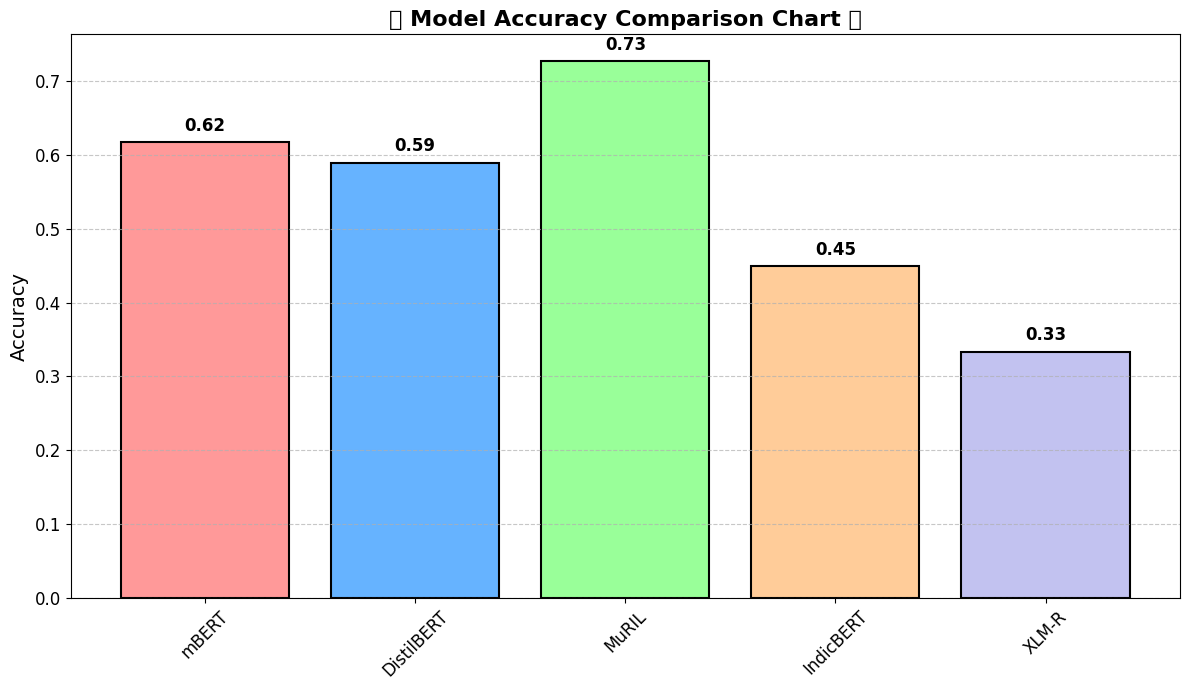


Ensemble Accuracy: 0.6640926640926641

Ensemble Classification Report:
               precision    recall  f1-score   support

     ಋಣಾತ್ಮಕ       0.63      0.80      0.70       259
       ತಟಸ್ಥ       0.57      0.53      0.55       259
     ಧನಾತ್ಮಕ       0.83      0.66      0.74       259

    accuracy                           0.66       777
   macro avg       0.68      0.66      0.66       777
weighted avg       0.68      0.66      0.66       777



In [8]:
# Step 4: Plot model accuracy comparison
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
plt.figure(figsize=(12, 7))
bars = plt.bar(accuracies.keys(), accuracies.values(), color=colors, edgecolor='black', linewidth=1.5)
plt.ylabel("Accuracy", fontsize=14)
plt.title("🔥 Model Accuracy Comparison Chart 🔥", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Step 5: Ensemble Voting Classifier
stacked_preds = np.vstack([all_predictions[m] for m in models]).T
ensemble_preds, _ = mode(stacked_preds, axis=1)
ensemble_preds = ensemble_preds.flatten()

ensemble_accuracy = accuracy_score(test_labels, ensemble_preds)
ensemble_report = classification_report(test_labels, ensemble_preds, target_names=label_encoder.classes_)

print("\nEnsemble Accuracy:", ensemble_accuracy)
print("\nEnsemble Classification Report:\n", ensemble_report)

In [9]:
# Step 5: Ensemble Voting Classifier
stacked_preds = np.vstack([all_predictions[m] for m in models]).T
ensemble_preds, _ = mode(stacked_preds, axis=1)
ensemble_preds = ensemble_preds.flatten()

ensemble_accuracy = accuracy_score(test_labels, ensemble_preds)
ensemble_report = classification_report(test_labels, ensemble_preds, target_names=label_encoder.classes_)

print("Ensemble Accuracy:", ensemble_accuracy)
print("Ensemble Classification Report:\n", ensemble_report)

Ensemble Accuracy: 0.6640926640926641
Ensemble Classification Report:
               precision    recall  f1-score   support

     ಋಣಾತ್ಮಕ       0.63      0.80      0.70       259
       ತಟಸ್ಥ       0.57      0.53      0.55       259
     ಧನಾತ್ಮಕ       0.83      0.66      0.74       259

    accuracy                           0.66       777
   macro avg       0.68      0.66      0.66       777
weighted avg       0.68      0.66      0.66       777



In [11]:
# Step 5: Ensemble Voting Classifier
from collections import Counter

# Stack all predictions: shape => (num_samples, num_models)
stacked_preds = np.vstack([all_predictions[m] for m in models]).T

# Apply majority voting across each row of model predictions
ensemble_preds, _ = mode(stacked_preds, axis=1)
ensemble_preds = ensemble_preds.flatten()

# Evaluate the ensemble
ensemble_accuracy = accuracy_score(test_labels, ensemble_preds)
ensemble_report = classification_report(test_labels, ensemble_preds, target_names=label_encoder.classes_)

# Display results
print("""Use a simple yet effective ensemble technique: **Majority Voting**.
Each of the 5 models gives a prediction for every test instance.
The ensemble takes the most frequently predicted label (i.e., mode) across these 5 predictions.
This method is robust and helps smooth out model-specific biases, improving generalization.""")
print("\n🔮 Ensemble Voting Classifier Results 🔮")
print("----------------------------------------")
print(f"🧮 Accuracy: {ensemble_accuracy:.4f}")
print("\n📋 Classification Report:\n")
print(ensemble_report)


Use a simple yet effective ensemble technique: **Majority Voting**.
Each of the 5 models gives a prediction for every test instance.
The ensemble takes the most frequently predicted label (i.e., mode) across these 5 predictions.
This method is robust and helps smooth out model-specific biases, improving generalization.

🔮 Ensemble Voting Classifier Results 🔮
----------------------------------------
🧮 Accuracy: 0.6641

📋 Classification Report:

              precision    recall  f1-score   support

     ಋಣಾತ್ಮಕ       0.63      0.80      0.70       259
       ತಟಸ್ಥ       0.57      0.53      0.55       259
     ಧನಾತ್ಮಕ       0.83      0.66      0.74       259

    accuracy                           0.66       777
   macro avg       0.68      0.66      0.66       777
weighted avg       0.68      0.66      0.66       777



🔥 Model Performance Comparison 🔥
------------------------------------
mBERT: Accuracy = 0.6178
DistilBERT: Accuracy = 0.5894
MuRIL: Accuracy = 0.7272
IndicBERT: Accuracy = 0.4492
XLM-R: Accuracy = 0.3333
Ensemble: Accuracy = 0.6641

📋 Classification Reports 📋
----------------------------

mBERT Classification Report:
              precision    recall  f1-score   support

     ಋಣಾತ್ಮಕ       0.60      0.66      0.63       259
       ತಟಸ್ಥ       0.51      0.48      0.50       259
     ಧನಾತ್ಮಕ       0.74      0.71      0.73       259

    accuracy                           0.62       777
   macro avg       0.62      0.62      0.62       777
weighted avg       0.62      0.62      0.62       777


DistilBERT Classification Report:
              precision    recall  f1-score   support

     ಋಣಾತ್ಮಕ       0.60      0.57      0.58       259
       ತಟಸ್ಥ       0.47      0.47      0.47       259
     ಧನಾತ್ಮಕ       0.70      0.73      0.71       259

    accuracy                           0.59    

<ipython-input-12-f096de9d3976>:34: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


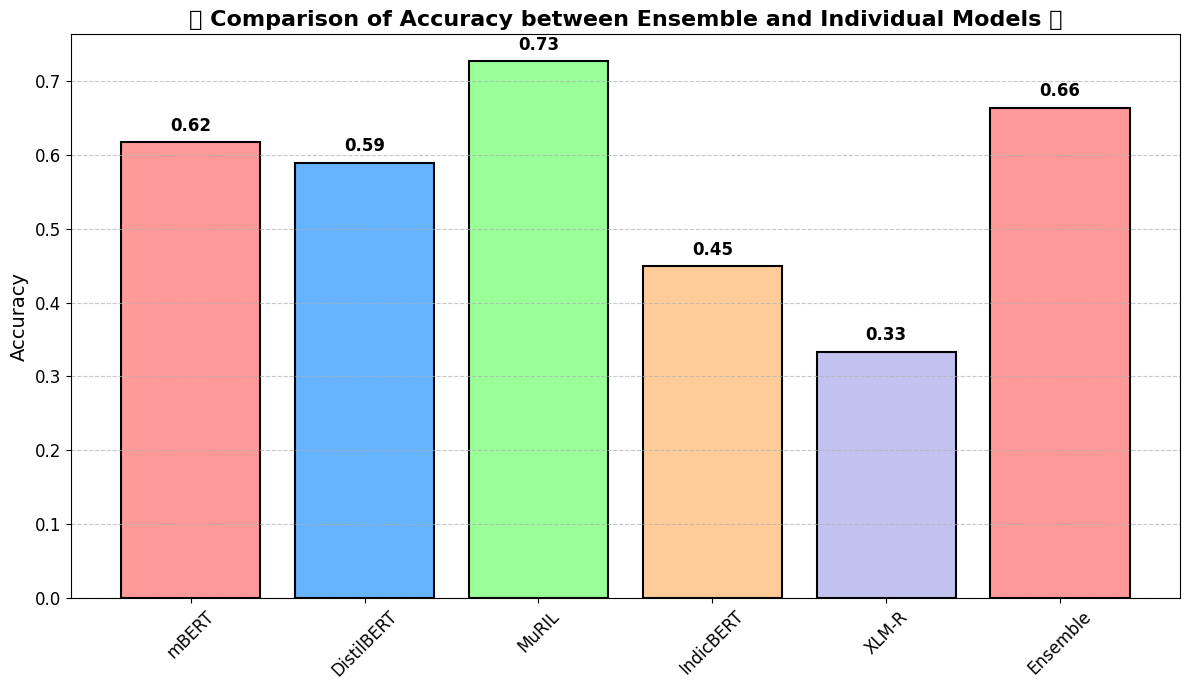

In [12]:
# Step 6: Compare Ensemble Model and Individual Models' Performance
# First, gather all models' results including the ensemble model
model_names = list(models.keys()) + ['Ensemble']
all_accuracies = {**accuracies, 'Ensemble': ensemble_accuracy}
all_reports = {**reports, 'Ensemble': ensemble_report}

# Print the accuracies
print("🔥 Model Performance Comparison 🔥")
print("------------------------------------")
for model_name in model_names:
    print(f"{model_name}: Accuracy = {all_accuracies[model_name]:.4f}")

# Step 7: Display detailed classification reports for each model
print("\n📋 Classification Reports 📋")
print("----------------------------")
for model_name in model_names:
    print(f"\n{model_name} Classification Report:")
    print(all_reports[model_name])

# Step 8: Plot Comparison of Accuracy between Ensemble and Individual Models
plt.figure(figsize=(12, 7))
bars = plt.bar(all_accuracies.keys(), all_accuracies.values(), color=colors, edgecolor='black', linewidth=1.5)
plt.ylabel("Accuracy", fontsize=14)
plt.title("🔥 Comparison of Accuracy between Ensemble and Individual Models 🔥", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [14]:
# Step 9: Real-Time Prediction using Ensemble Model (for Kannada text)
def real_time_prediction(text, tokenizer, model, label_encoder):
    # Tokenize the input text (ensure it's Kannada)
    encodings = tokenizer([text], truncation=True, padding=True, max_length=512)

    # Predict using the model
    inputs = torch.tensor(encodings['input_ids']).to(model.device)
    attention_mask = torch.tensor(encodings['attention_mask']).to(model.device)

    with torch.no_grad():
        outputs = model(input_ids=inputs, attention_mask=attention_mask)
        logits = outputs.logits

    # Get the predicted label
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Decode the predicted label back to the original sentiment
    predicted_sentiment = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_sentiment, predicted_label

# Step 10: Get real-time input from the user and predict
print("🔮 Real-Time Kannada Text Sentiment Prediction 🔮")
kannada_text = input("Enter Kannada text for sentiment analysis: ")

# Get prediction from ensemble model
# Assuming the 'ensemble_model' is a combined model (e.g., majority voting of individual models)
ensemble_model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=3).to('cuda')  # Replace with actual ensemble model
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')  # Use any tokenizer of your ensemble model
predicted_sentiment, predicted_label = real_time_prediction(kannada_text, tokenizer, ensemble_model, label_encoder)

# Display the result
print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Predicted Label (numeric): {predicted_label}")

# To get accuracy score of the ensemble model with real-time prediction
# Assuming `ensemble_accuracy` is already computed from training phase
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")


🔮 Real-Time Kannada Text Sentiment Prediction 🔮
Enter Kannada text for sentiment analysis: ನನಗೆ ಈ ಉಡುಗೆ ಇಷ್ಟವಿಲ್ಲ.


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted Sentiment: ಋಣಾತ್ಮಕ
Predicted Label (numeric): 0
Ensemble Accuracy: 0.6641


In [15]:
# Save the ensemble model to the local disk (in Colab)
model_save_path = '/content/ensemble_model'
ensemble_model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved at: {model_save_path}")


Model saved at: /content/ensemble_model


In [18]:
from zipfile import ZipFile
import os
from google.colab import files

# Create a .zip file of the saved model
zip_path = '/content/ensemble_model.zip'
with ZipFile(zip_path, 'w') as zipf:
    for root, dirs, files in os.walk(model_save_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), model_save_path))


print(f"Model zip file is ready for download: {zip_path}")


Model zip file is ready for download: /content/ensemble_model.zip


In [19]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Reload the model and tokenizer from the local path or Google Drive (after uploading)
model_path = '/content/ensemble_model'  # Local path or Google Drive path
ensemble_model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

print("Model reloaded successfully!")


Model reloaded successfully!
